<a href="https://colab.research.google.com/github/rara-by/Practice-Notebooks/blob/main/Copy_of_2023_NLP_SanskritGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tutorial by Vivek


In [ ]:
# For English dataset please run this
# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
# Dataset and Saved Model: https://drive.google.com/drive/folders/1-0AhDOtpVd-RhAOZP_JvpGbhKnXuDoSR?usp=sharing

go to the link ^ and downlad the dataset and upload here

In [2]:
filename="Rig_Veda_3"
savefilepath=f"/content/{filename}.txt"
# length of dataset in characters in Shakespear:  1115394
#
# In Ramayan: 1562638

with open(savefilepath, 'r', encoding='utf-8') as f:
    text = f.read()
print("length of dataset in characters: ", len(text))

length of dataset in characters:  809765


In [3]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open(savefilepath, 'r', encoding='utf-8') as f:
    text = f.read()


In [4]:
device # checck the device whether you are using cuda or not

'cuda'

In [7]:

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(vocab_size)

# character level tokenizer
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) } # We are basically creating a look up table here
itos = { i:ch for i,ch in enumerate(chars) }

# print(stoi)

encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]


62


In [8]:
stoi # Here we can see how each character is encoded to an integer

{'\n': 0,
 ' ': 1,
 '|': 2,
 'ं': 3,
 'ः': 4,
 'अ': 5,
 'आ': 6,
 'इ': 7,
 'ई': 8,
 'उ': 9,
 'ऊ': 10,
 'ए': 11,
 'ऐ': 12,
 'ओ': 13,
 'औ': 14,
 'क': 15,
 'ख': 16,
 'ग': 17,
 'घ': 18,
 'ङ': 19,
 'च': 20,
 'छ': 21,
 'ज': 22,
 'झ': 23,
 'ञ': 24,
 'ट': 25,
 'ठ': 26,
 'ड': 27,
 'ढ': 28,
 'ण': 29,
 'त': 30,
 'थ': 31,
 'द': 32,
 'ध': 33,
 'न': 34,
 'प': 35,
 'फ': 36,
 'ब': 37,
 'भ': 38,
 'म': 39,
 'य': 40,
 'र': 41,
 'ल': 42,
 'ळ': 43,
 'व': 44,
 'श': 45,
 'ष': 46,
 'स': 47,
 'ह': 48,
 'ऽ': 49,
 'ा': 50,
 'ि': 51,
 'ी': 52,
 'ु': 53,
 'ू': 54,
 'ॄ': 55,
 'े': 56,
 'ै': 57,
 'ो': 58,
 'ौ': 59,
 '्': 60,
 'ॠ': 61}

In [9]:
train_data.shape, val_data.shape

(torch.Size([728788]), torch.Size([80977]))

block_size: maximum context length for prediction <br>
batch_size: number of independent blocks to process in parallel

In [ ]:

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y


"""
@torch.no_grad()
Disabling gradient calculation is useful for inference,
when you are sure that you will not call Tensor.backward().
It will reduce memory consumption for computations that would otherwise have requires_grad=True.
"""

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model--
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (Batch ,Ttime (context winddow) ,Channel (how embeddings are returned))
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


In [ ]:

# model =BigramLanguageModel()

# If you have saved your model you can load the model from there.
# And run the below code during inference
PATH="/content/drive/MyDrive/Bibek/sanskrit_data/model1.pth" # Your path will be different from mine
model.load_state_dict(torch.load(PATH))
# model.eval() # Because we are evaluating the model it is should be model.eval()"""

<All keys matched successfully>

In [ ]:
m = model.to(device) # We are now loading our model to the device

In [ ]:
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
#max_iters= 5000



0.209342 M parameters


In [ ]:
# Only run this for training
PATH= "/content/drive/MyDrive/Bibek/sanskrit_data/model1.pth"
for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    if (iter % 1000) == 0:
      print("#Saving the model now")
      torch.save(model.state_dict(), PATH)



step 0: train loss 2.0344, val loss 2.0629
#Saving the model now
step 100: train loss 2.0357, val loss 2.0583
step 200: train loss 2.0262, val loss 2.0583
step 300: train loss 2.0261, val loss 2.0662
step 400: train loss 2.0225, val loss 2.0439
step 500: train loss 2.0201, val loss 2.0558
step 600: train loss 2.0232, val loss 2.0417
step 700: train loss 2.0107, val loss 2.0403
step 800: train loss 2.0132, val loss 2.0435
step 900: train loss 2.0048, val loss 2.0375
step 1000: train loss 2.0090, val loss 2.0470
#Saving the model now
step 1100: train loss 1.9972, val loss 2.0424
step 1200: train loss 1.9983, val loss 2.0280
step 1300: train loss 1.9892, val loss 2.0398
step 1400: train loss 1.9977, val loss 2.0377
step 1500: train loss 1.9995, val loss 2.0336
step 1600: train loss 1.9920, val loss 2.0379
step 1700: train loss 1.9862, val loss 2.0291
step 1800: train loss 1.9946, val loss 2.0347
step 1900: train loss 1.9804, val loss 2.0174
step 2000: train loss 1.9795, val loss 2.0178
#S

In [ ]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


आ इळ इन्द्रा वे्जानस्तापित्थाः|
अर्वाञ्चाश्वीरिङ हि दीशतः सवाराः|
शतमानः सह पिष्ठः पर्वत|
परोतीः|
एवेषस पनतुरूम्र उभयो मु शथेषुभिः सम्रस्य गीरिभिर्जन्ने वर्त्रा च सुस्वतो जघान|
तिर्भुजन्त विश्वे असोरिषः सवसरुः|
यू ंहिरा शारिरस्मं तन्यक्र्णानीनाम|
यदा विदथाय वर्षिष्टिषुरा सघम इधत समनं गोहाम इव परगीर्भिरान्रिरन्र्णम ऐरते दूतो न एहि|
सा नो मे भूाद दिविस्प्र ऊंर्तमं रथावांसो अक्र्ण आ चक्रिं चक्रेत कं कर्णाम अम्र्तस्य धीभिरिषि सवधर्यम|
अध्र्मं नेतामसो विर्णतः|
हव्यवाय चकार वीव्या पिब तवा जविष्टिम|
उत वा सप्तासः|
तवं हव्यः शन्तमनाभ्येकश्विना राजभरसे|
सिन्धमन्तमं नू अद्यां यथा कर्णां युयुक्ते|
परत्र्महो शरुतः किमं नद्यं हव्यसे|
दवेषपेयवे दधिरे रथमं सुप्रा वीळ्हानोदग्नेः|
ययः को भिया तर्पसेशतुं रायसा इद ईव जयता नितर्षतान्र्व्र्ध्वं दिवे|
तेभ्यं घेतं विदित्रिभिरर्काणसो वय इन्द्र बरह्मयः|
हन्ते न ईमकेम|
पत्यं देवा अश्मिनानग्निरे|
रथं नु शवसा सुष्ट्रमस्मण सुजाता पर ते अग्र पीतये उत्र रुद्रमा हरी गोर हवयो जनाना विदथ|
पिप्राश्चिद रेतसः|
तवां होतारं हि वा यतन पत्नीमो हेतामयाः|
सवगतव उभावद वजरं कस्य

In [ ]:
# # generate from the model
# context = torch.zeros((1, 1), dtype=torch.long, device=device)
# print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


परविणा वत्सु रुद्रवद देवानाः सियम|
पुरुत्रः सुक्थ्ये अर्यो मातामुषाय न पोषम|
अग्ने पिनोयन्निना|
भमाव वेरं नि पत्वीरं न यज्ञियः बुनः|
पूरवन्न सरसा निं विल्युभिः|
तस्मा गतं रसी वर्तचित्रेण्यो देवो नप्तनीनां सुम्हया|
सा सहीनां रायो नराभिर्र्त्ना धर्तं सदनानानो विजानं धा ते वदूमन्यम्छान|
अर्या दरा रोहतः सुमपस्युः सहनक्तस्या अद्या वरंचस्य कष्टवः सविता वरता हिरण्यये वर्ष्ट्रे वो व अन्तरस्य पीतयः|
आकं तवान गमद्व्यवः पुनः परथम ईं चिद धया|
उपस्यः परि मंधमा भर|
गुषे बर्हस्पतिस्राम|
उपस्तेन यूथाः|
परवर्णाना सि देवाना जयेभिर्विश्वान तिथुम अगनिमत्तरेभिस्तीरिव|
अग्निस्ते मन्दसं रिप्र्ष्टुरा गातोर्विद्दस्रेरं वव्रिरो|
विषर्क आपि जुगसमु वजोषन गमहे हिरण्ययूत|
यत तवाता वर्षाकम अर्यमाना हवा सरस्वच्चक्षत सुतः|
पुन्वतते मधुनं पयं शक्रुभिरद|
बर्हिरी सुतानो न सुव्र्त्येभ्यः|
मम इन्द्र दर्गः पुरुक्ष आ भूम यदिन्द्रः|
परारवां पर्थिव्यामितरा जातस्वत्सादयासाम|
चतं तुरङग्रणि कोपिपा वर्त्रहन न सस्तुतो वरीवत्रं हवं नर कर्ण्वम|
अस्मयाकं शवसात परिया उग्रादुपय इव जरित्र वि सेतवे मर्त्यो धानस्य पुनोदस्पतो|
एवा कस्व सुक

In [ ]:
x=input("dont stop the colab")

KeyboardInterrupt: ignored

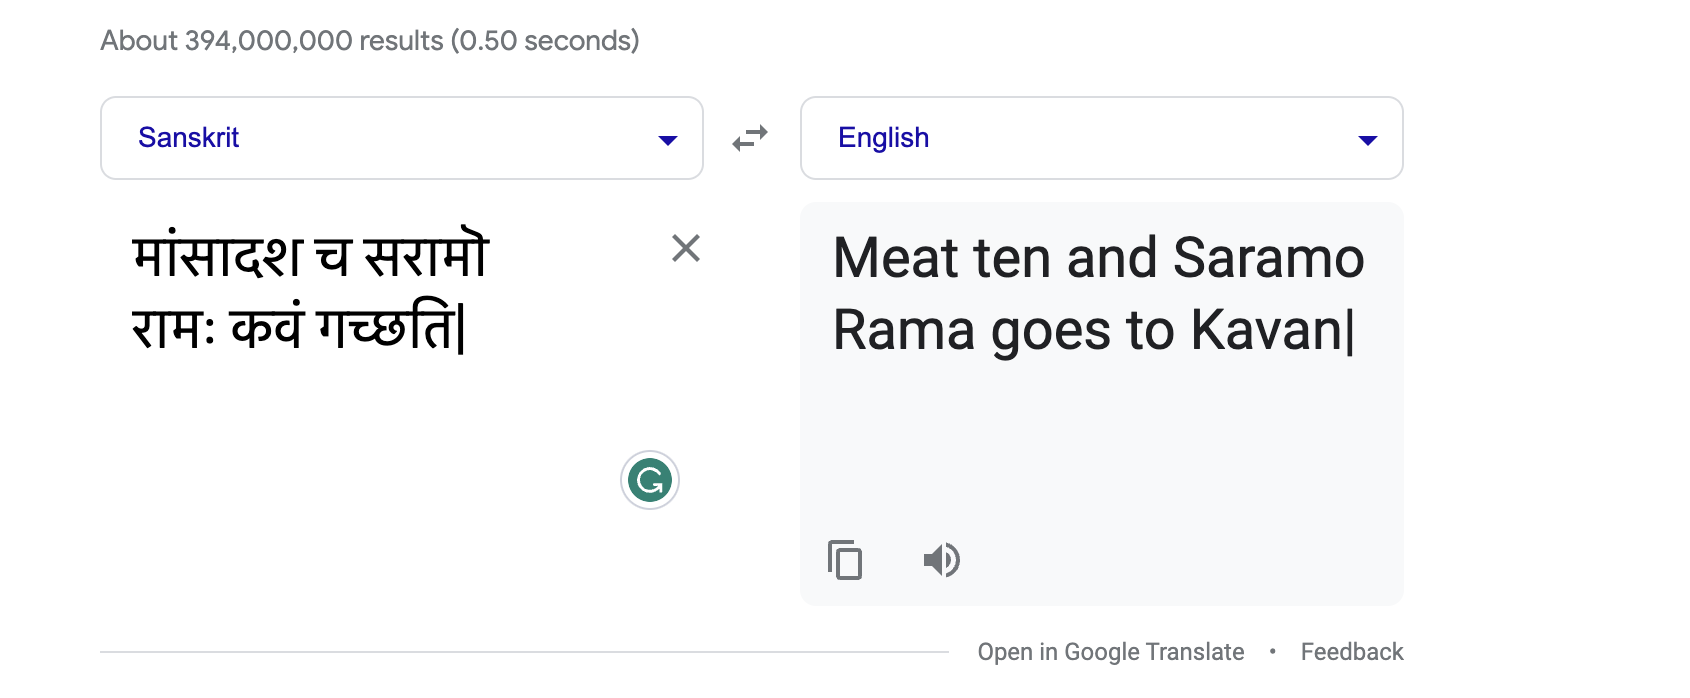

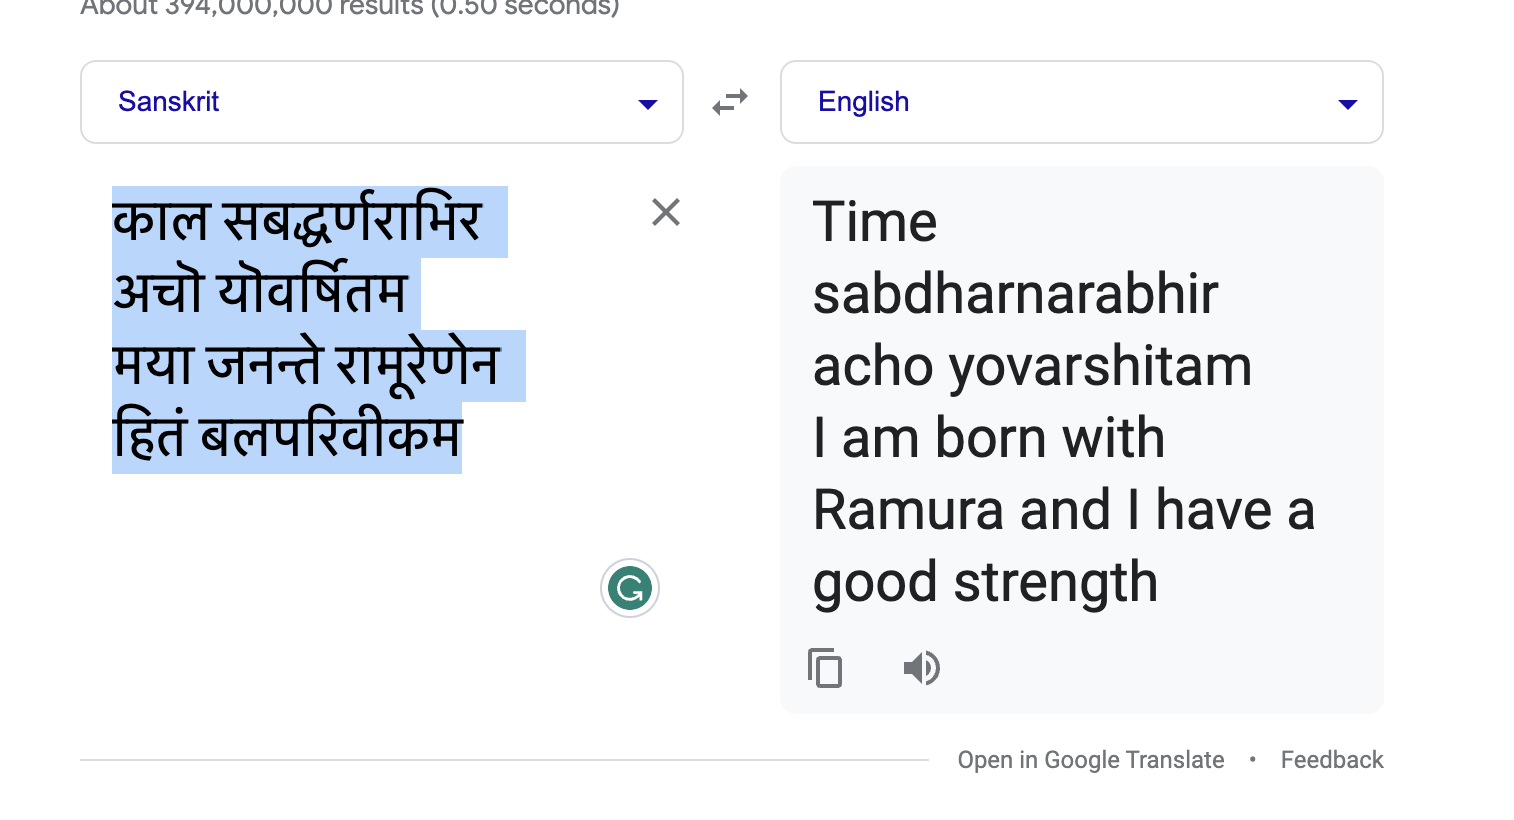

In [ ]:
context="अध्यर्धयॊजनं गत्वा नदीं पश्चान मुखाश्रिताम सरयूं पुण्यसलिलां ददर्श रघुनन्दनः"
x,y =get_batch(context)

In [ ]:
print(decode(m.generate(x, max_new_tokens=2000)[0].tolist()))

 सत्रीकृतं सर्वं सव्यालमृगपक्षिणः|
राज्यं परत्युमहस्पसंहृति च तदा वसनाम|
वृतिजागृहाय वैदेह लवनं विवानर्तमान अहशेरुराम|
अब्धम्भिं युक्तैः सुमहुबॊधविः|
गर्हन्तङ्फा परमततैः परत्नगं नरान्ताव आक्ताः सता कानुं चियाम|
इति पदिव्याय इदं नेशानां पूमं परियकासिनिशितमाः|
स कुद्ध्वर्णानि दृष्टॊ ऽननिभ्नुतम|
सहत्रिवृतमानि मथिवे दृशेकार्थिष्यन्ति चयमः|
शापदामनाब्रविशातुैस तुंसरक्षसॊययः|
भरात्माणि रामहरस्थः पुब महाविधिः|
यथा स रक्षशारः सुक्तस तद्विना पराप्रजः|
ददृशे चापानॊ वृतः शरण्तॊ बलिन रक्ष्यतिम|
गत्वसशु च हि वनसहाननाय राघवकनेनसूनः|
असित्वा हि रामः सुमाप्तपः परंगतः|
परियस ताव चाभिवेतुवम अभ्यावदानदूरं बुद्धिराम|
सर्वतस तवम औित्रान आजघ्नपे|
संलवः कर्माद बरतॊत्तेषा तथेनाडुणैः सह|
परप्रमाक्रौ यॊधारि राजानुतकॊधमन्तरां येन राम गमनः|
वचः करियुद्धॊ ऽलैः परिवाच राक्षसान|
अन्तस ततस्य कर्हभौ यहृद्विधना लङ्कातम|
आभुमाने रघुनन्दुखुण्भं मूलवनन्दना|
बबाहुर ज्ञिव्य सवन्थं नकरॊहिता मम शरीमतिमासुङ्गवः|
परग्मिकं पराकृता भगतान धिच्येन मां मृगापयिष्यतसम|
सत्रियः सपुत्रम|
शास्यन्ति विमृद्धम एषॊः सुगेन्द्रुत्याः|
शयॊद्ये 

In [ ]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


गजलांुसाम|
शल्पलैर अतिश्विषा तथावदित्य अधनुः पुता ऽहं परहृदमहॊरकाम|
दृशा घॊरन मन्तान कुत्वैः संसर्ज्वश च महानां सर्वे शतकं चमुरॊपाङ्गमिनः|
तस्याद गृह्य ददर्शनां मम उक्त्वां चीरान उङ्चनेन च पेवनाम अत्रामकाशिनः|
यतामि सुगह्यं हरापान आशतृहसलानि पराप्लुष्टकण्मा महाक वचाक्रशं मदानान वास्तां साधिनॊ न नरक्ता यपुंचित|
लपाताः पर्युक्तसु वृत्थैता वयवस्थं शरुत्वा तत्र्भॊ रहरान्तः सर्वरवैश च काप्य आगतेज्वितः|
परत्येव भरत्य परिदिव्यॊ यदस्य भित्रिस्यतस तवः|
परहॊ ऽपि च च इन्द्रसंधृश च मयासिनः|
इत्य शुभिर उद्यथा ददृशस्य इवानव्यृतः|
स गरशारहृतॊपं राक्षसाद अपि च मनः|
भवितद वस्यभस्थम इद वीर्यान करथः|
कारॊ वसिनीग्नाद इहम अब्रवे|
भरतस तन्याय आहलुत्ते वनः संख्यं यशॊकास तु|
रामसंदतद रामः खलॊ यथा मया महितौ|
सर्वाँलाः परतीप्स सुवृतस तु तस्मिन हि मयिष्ठामि काकात्मना|
विनामशत्य सकर्ीलित्रितुं तेन मौ|
आपतन्या बमुन्द अक्षन्ती कश्यातम अनिरप्रभः|
एवम अकामान आसैन्यति धर्मजं पुत्रॊ ऽपि नापि धरामृदेव परतिगिपाल|
न मम कषिप्रैः स संख्य परिप्तान इष्ठः परेक्रति विमलम|
तॊरियं निश्य पलुपतितां समाशुसः|
समाम आभाम इवायामि पाप्त